In [507]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy.ndimage as spi
import os
import pandas as pd
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from astropy.nddata import Cutout2D
from skimage import restoration
import astropy as astro
from astropy.io import fits
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pylab as pylab
import astropy.units as u

plt.style.use("science")
params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
pylab.rcParams.update(params)

# from reproject import reproject_interp

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180
%matplotlib inline

In [508]:
datapath = "../data/hst_mos_0043768_acs_wfc_f814w_drz.fits"
data = fits.open(datapath)

In [509]:
data.info()

Filename: ../data/hst_mos_0043768_acs_wfc_f814w_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     883   ()      
  1  SCI           1 ImageHDU        82   (7600, 6800)   float32   
  2  WHT           1 ImageHDU        47   (7600, 6800)   float32   
  3  CTX           1 ImageHDU        40   (7600, 6800)   int32   
  4  HDRTAB        1 BinTableHDU    631   10R x 311C   [9A, 3A, J, D, D, D, D, D, D, D, D, D, D, D, D, D, J, 8A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, J, 8A, 23A, D, D, D, D, J, J, J, 8A, J, 23A, 9A, 19A, J, 4A, J, J, J, J, J, J, 23A, D, D, D, D, J, J, 3A, 23A, 4A, 4A, J, D, D, D, 3A, 1A, J, D, D, D, 13A, 3A, 4A, 4A, 12A, 12A, 23A, 8A, 23A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 23A, D, J, D, 6A, 9A, 8A, D, D, J, 4A, 18A, 3A, J, 7A, 5A, 3A, D, 13A, 8A, 4A, 3A, J, J, J, J, J, J, J, D, D, D, D, D, D, 23A, 1A, D, 23A, D, D, D, 3A, 23A, J, 1A, 3A, 1A, D, 3A, 6A, J, D, D, D, D, D, D, D, D, D, 

In [510]:
data["SCI"].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 7600                                                  
NAXIS2  =                 6800                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1                                                  
BUNIT   = 'ELECTRONS/S'        / Units of science product                       
                                                                                
CD1_1   = -1.1111111111111E-

In [511]:
data["SCI"].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 7600                                                  
NAXIS2  =                 6800                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1                                                  
BUNIT   = 'ELECTRONS/S'        / Units of science product                       
                                                                                
CD1_1   = -1.1111111111111E-

In [512]:
# multiply the image by the weight so unit is now in Electron Count instead of Electron/s
exptime = data["PRIMARy"].header["EXPTIME"]
print(f"exposure time: {exptime} s")
image = data["SCI"].data * exptime #* data["WHT"].data / data["WHT"].data.sum()
weights = data["WHT"].data

exposure time: 1980.0 s


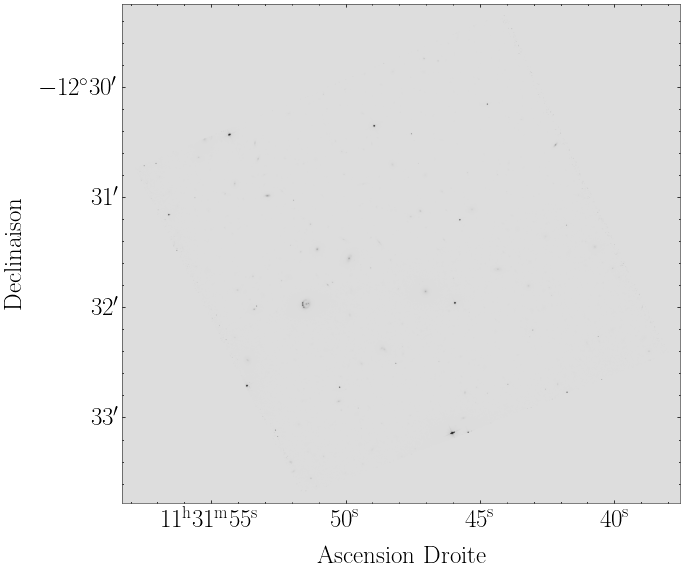

In [513]:
wcs = WCS(data["SCI"].header)
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(image, cmap="gray_r", norm=ImageNormalize(interval=ZScaleInterval(), stretch=LogStretch()))

ax = plt.gca()
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison');

In [514]:
centroid = SkyCoord(172.96435966, -12.53284896, unit="deg")
centroid = centroid.to_pixel(wcs)
centroid

(array(2511.43624434), array(2705.39444813))

In [515]:
size = 175 * u.pixel
cutout = Cutout2D(image, centroid, size, wcs=wcs)
cutout_image = cutout.data
wcs_cutout = cutout.wcs
cutout_image[cutout_image < 0] = 0

In [516]:
cutout = Cutout2D(weights, centroid, size, wcs=wcs)
cutout_weights = cutout.data

In [517]:
mean, median, std = sigma_clipped_stats(cutout_image,  sigma=3.0)
print(mean, median, std)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(cutout_image)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
center = 4

object_positions = sources[[7, 3, 1, 5, 4, 6]]["xcentroid", "ycentroid"].to_pandas().to_numpy() # B, A, C, D, G, S
ox, oy = object_positions[:, 0], object_positions[:, 1]

225.2698974609375 134.15936279296875 206.12289428710938


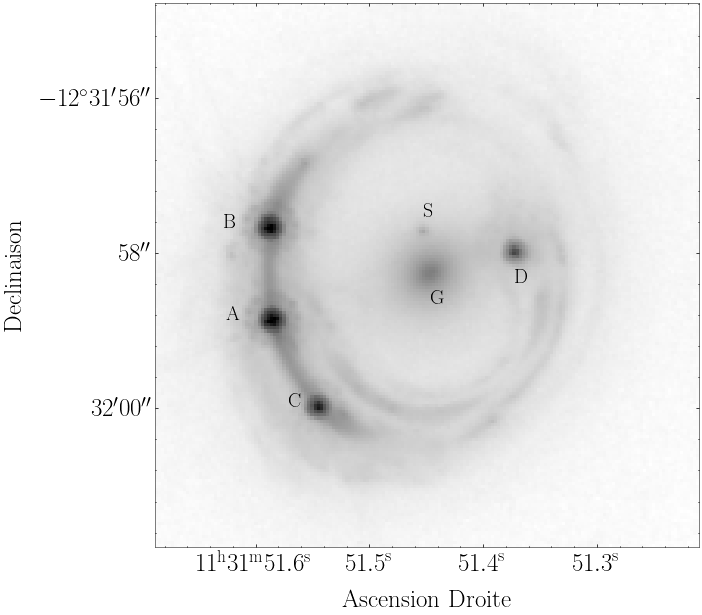

In [530]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs_cutout)
plt.imshow(cutout_image, cmap="gray_r", norm=ImageNormalize(interval=ZScaleInterval(), stretch=LogStretch()))
# plt.imshow(cutout_image > cutout_image.std())
ax = plt.gca()
ax.annotate("A",  [ox[1]-15, oy[1]], color="k", fontsize=20)
ax.annotate("B",  [ox[0]-15, oy[0]], color="k", fontsize=20)
ax.annotate("C",  [ox[2]-10, oy[2]], color="k", fontsize=20)
ax.annotate("D",  [ox[3], oy[3]-10], color="k", fontsize=20)
ax.annotate("G",  [ox[4], oy[4]-10], color="k", fontsize=20)
ax.annotate("S",  [ox[5], oy[5]+5], color="k", fontsize=20)
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison');

In [519]:
# make sure to include exposure time for proper STMag computation by GalFit
header = wcs_cutout.to_header()
header["EXPTIME"] = exptime
new_hdul = fits.HDUList()
new_hdul.append(fits.PrimaryHDU(data=cutout_image, header=header))
new_hdul.writeto("../data/rxj1131_cutout.fits", overwrite=True)

In [520]:
N = cutout_image.shape[1]
x = np.arange(N) - N//2
M = cutout_image.shape[0]
y = np.arange(M) - M//2
xx, yy = np.meshgrid(x, y)
rho = np.hypot(xx, yy)

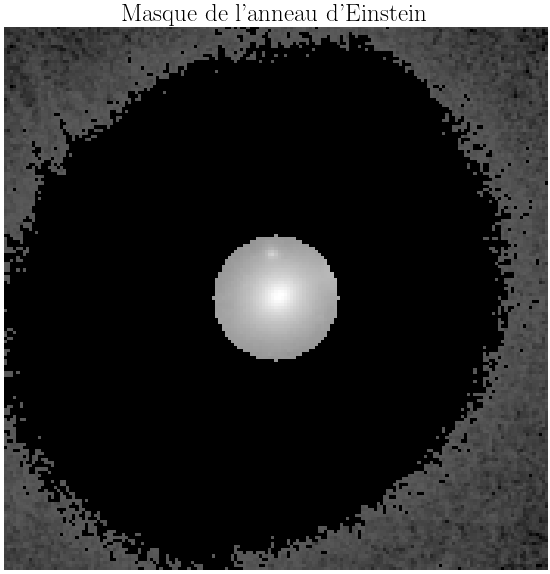

In [521]:
# create mask for galfit so it does not have problem with the Eistein ring and 4 images bad pixel have value>0, good pixel have value=0 
plt.figure(figsize=(10, 10))
b_map = np.zeros_like(cutout_image)
b_map += (rho > 20) & (cutout_image > 0.4*std)
plt.imshow(cutout_image * (~b_map.astype(bool)), norm=ImageNormalize(stretch=LogStretch()), origin="lower", cmap="gray")
plt.axis("off")
plt.title("Masque de l'anneau d'Einstein")
plt.savefig("../latex/final_report/figures/bad_pixel_map.png")

In [522]:
new_hdul = fits.HDUList()
new_hdul.append(fits.PrimaryHDU(data=b_map, header=wcs_cutout.to_header()))
new_hdul.writeto("../data/rxj1131_bad_pixel_map_galfit.fits", overwrite=True)

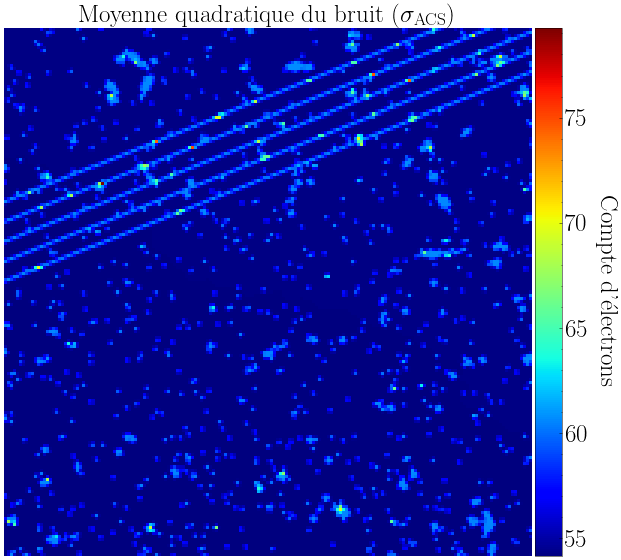

In [533]:
noise_map = exptime * np.sqrt(1/cutout_weights)

fig = plt.figure(figsize=(10, 10))
im = plt.imshow(noise_map, cmap="jet", origin="lower")
ax = plt.gca()
plt.axis("off")
ax.set_title("Moyenne quadratique du bruit ($\sigma_{\mathrm{ACS}}$)", fontsize=25)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel("Compte d'électrons", rotation=270,)
plt.savefig("../latex/final_report/figures/noise_map.png")

In [524]:
new_hdul = fits.HDUList()
new_hdul.append(fits.PrimaryHDU(data=cutout_weights, header=wcs_cutout.to_header()))
new_hdul.writeto("../data/rxj1131_cutout_weights.fits", overwrite=True)

In [525]:
new_hdul = fits.HDUList()
new_hdul.append(fits.PrimaryHDU(data=noise_map, header=wcs_cutout.to_header()))
new_hdul.writeto("../data/rxj1131_cutout_noise_map.fits", overwrite=True)

In [526]:
np.sqrt(exptime**2 / cutout_weights).mean()

54.898724

In [527]:
# after galfit
block = fits.open("../data/blocks1.fits")

(-0.5, 174.5, -0.5, 174.5)

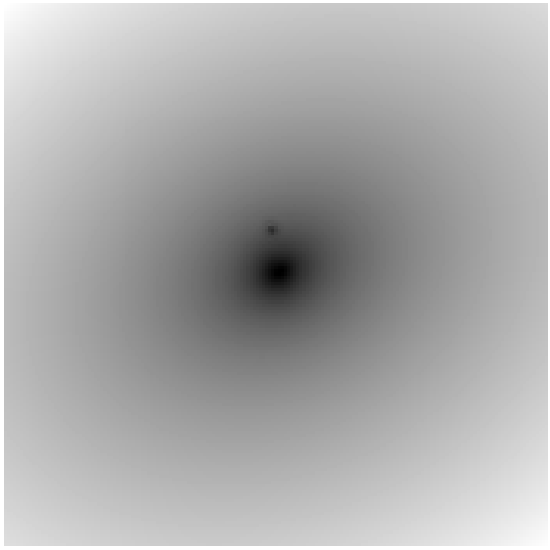

In [528]:
# fit
plt.figure(figsize=(10, 10))
# plt.subplot(projection=wcs_cutout)
plt.imshow(block[2].data, cmap="gray_r", norm=ImageNormalize(interval=ZScaleInterval(), stretch=LogStretch()), origin="lower")
plt.axis("off")

Text(0.5, 1.0, 'Décomposition des galaxies G et S')

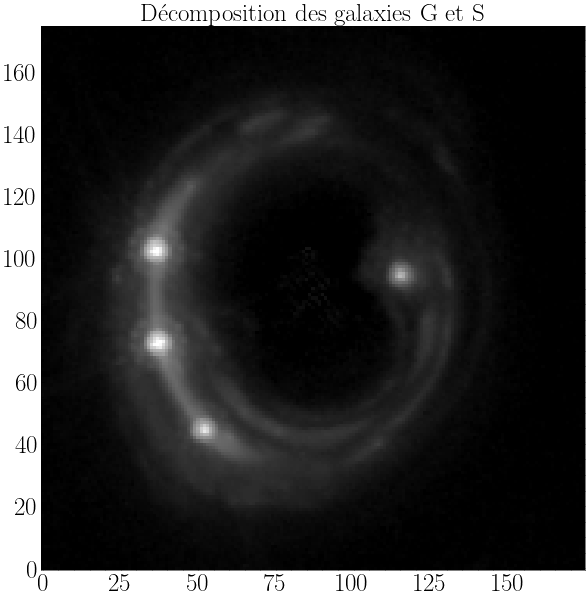

In [529]:
# residual
residual = block[3].data
residual[residual < 0] = 0
plt.figure(figsize=(10, 10))
# plt.subplot(projection=wcs_cutout)
plt.imshow(residual, cmap="gray", norm=ImageNormalize(interval=ZScaleInterval(), stretch=LogStretch()), origin="lower")
plt.title("Décomposition des galaxies G et S")
# plt.axis("off")
# plt.imshow(residual > 0)
# plt.colorbar()

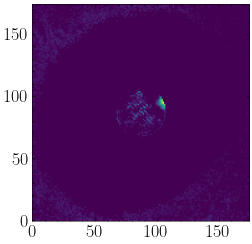

In [484]:
plt.imshow(residual * (~b_map.astype(bool)), origin="lower")

In [485]:
block[2].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                  175 / Length of data axis 1                          
NAXIS2  =                  175 / Length of data axis 2                          
OBJECT  = 'model   '           / Component type                                 
COMMENT ========== GALFIT Input Parameters ==========                           
INITFILE= 'galfit.feedme'      / GALFIT input file                              
DATAIN  = 'data/rxj1131_cutout.fits' / Input data image                         
SIGMA   = 'data/rxj1131_cutout_weights.fits' / Input sigma image                
PSF     = 'data/rxj1131_psf1.fits ' / Convolution PSF and kernel                
CONSTRNT= 'constraints.constraints' / Parameter constraint file                 
MASK    = 'data/rxj1131_bad_

In [486]:
ps = 0.04

In [487]:
# effective radius in arceseconds (pixelscale = 0.04)
re_1 = float(block[2].header["1_RE"][:7])
dre_1 = float(block[2].header["1_RE"][11:18])
print(f"1) R_e = {re_1 * ps} +/- {dre_1 * ps:.5f}")

1) R_e = 0.211728 +/- 0.00212


In [488]:
re_2 = float(block[2].header["2_RE"][:6])
dre_2 = float(block[2].header["2_RE"][12:19])
print(f"2) R_e = {re_2 * ps} +/- {dre_2 * ps:.5f}")

2) R_e = 5.2752 +/- 0.09190


In [489]:
# position in arcsecond (from South-Est corner of the image)
x_1 = float(block[2].header["1_XC"][:7])
dx_1 = float(block[2].header["1_XC"][11:18])
print(f"1) x_c = {x_1 * ps} +/- {dx_1 * ps:.5f}")
y_1 = float(block[2].header["1_YC"][:7])
dy_1 = float(block[2].header["1_YC"][11:18])
print(f"1) y_c = {y_1 * ps} +/- {dy_1 * ps:.5f}")

y_2 = float(block[2].header["2_YC"][:7])
dy_2 = float(block[2].header["2_YC"][11:18])
print(f"1) y_c = {y_2 * ps} +/- {dy_2 * ps:.5f}")
y_2 = float(block[2].header["2_YC"][:7])
dy_2 = float(block[2].header["2_YC"][11:18])
print(f"1) y_c = {y_2 * ps} +/- {dy_2 * ps:.5f}")

1) x_c = 3.533824 +/- 0.00057
1) y_c = 3.503472 +/- 0.00059
1) y_c = 3.549952 +/- 0.00033
1) y_c = 3.549952 +/- 0.00033


In [455]:
block[1].header


XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  175 / Length of data axis 1                          
NAXIS2  =                  175 / Length of data axis 2                          
PCOUNT  =                    0 / number of random group parameters              
GCOUNT  =                    1 / number of random groups                        
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               1376.0 / Pixel coordinate of reference point            
CRPIX2  =                782.0 / Pixel coordinate of reference point            
PC1_1   = -1.1111111111111E-05 / Coordinate transformation matrix element       
PC2_2   =  1.1111111111111E-05 / Coordinate transformation matrix element       
CDELT1  =                  1

In [497]:
# point de référence
ref = wcs_cutout.pixel_to_world(0, 0)
print(ref.ra.to(u.hourangle), ref.dec.to(u.deg))

11h31m51.687s -12d32m01.7633s
